# 1. 검증용 데이터셋 준비

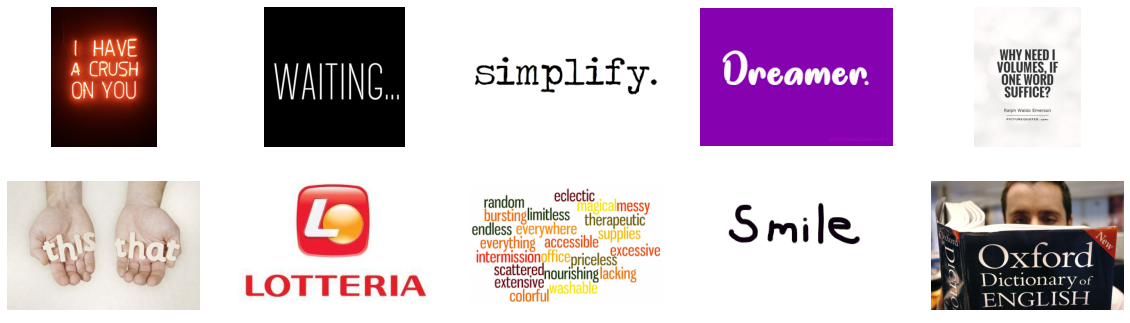

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image 
%matplotlib inline

IMG_CNT = 10
test_img_path = os.getenv('HOME')+'/aiffel/ocr_python/images/'
test_img_list = [test_img_path + f'{i}.jpg' for i in range(0, IMG_CNT)]
plt.figure(figsize=(20, 15))

for i, img in enumerate(test_img_list):
    temp_img = Image.open(img)
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(temp_img)
    

plt.show()

# 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

## 1) Google OCR API

In [2]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [3]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/dotted-ranger-333911-e72490bd0969.json'

for img in test_img_list:
    detect_text(img)
    print('-'*20)

total 12
drwxr-xr-x 36 root root 4096 Dec  2 11:33  aiffel
-rw-r--r--  1 root root 5041 Dec  2 13:25 '[E-18]OCR.ipynb'
Texts:

"I HAVE
A CRUSH
ON YOU
"

"I"

"HAVE"

"A"

"CRUSH"

"ON"

"YOU"
bounds: (480,711),(799,710),(800,877),(481,878)
--------------------
Texts:

"WAITING.
"

"WAITING."
bounds: (36,192),(451,192),(451,313),(36,313)
--------------------
Texts:

"simplify.
"

"simplify."
bounds: (10,62),(269,64),(269,115),(10,113)
--------------------
Texts:

"Oreamer.
Cohortstatuscuotes.com
"

"Oreamer."

"Cohortstatuscuotes.com"
bounds: (177,178),(258,179),(258,183),(177,182)
--------------------
Texts:

"WHY NEED I
VOLUMES, IF
ONE WORD
SUFFICE?
Ralph Waldo Emerson
PICTURE QUOTES.com
"

"WHY"

"NEED"

"I"

"VOLUMES,"

"IF"

"ONE"

"WORD"

"SUFFICE?"

"Ralph"

"Waldo"

"Emerson"

"PICTURE"

"QUOTES.com"
bounds: (234,521),(346,521),(346,539),(234,539)
--------------------
Texts:

"th that
"

"th"

"that"
bounds: (466,198),(704,212),(695,356),(457,342)
--------------------
Texts:

"L

## 2. keras-ocr

In [4]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 

images = [ keras_ocr.tools.read(url) for url in test_img_list]
prediction_groups = [pipeline.recognize([url]) for url in test_img_list]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


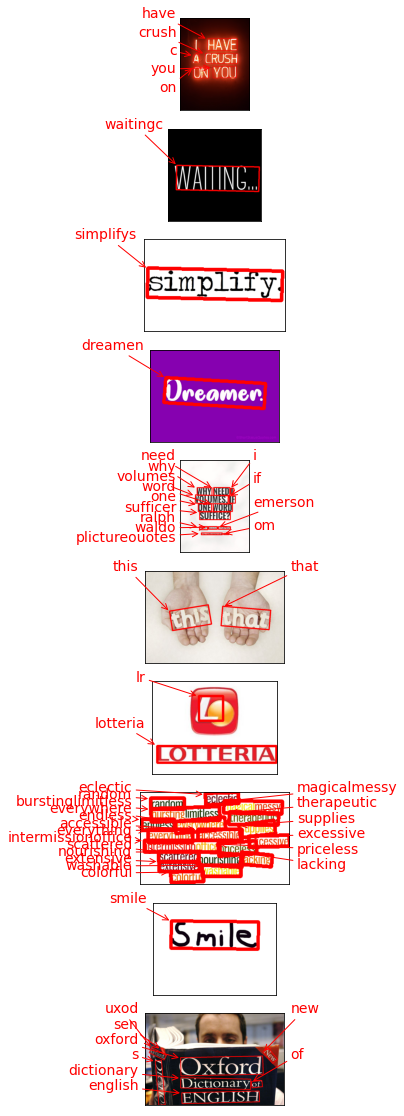

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 3) Tesseract

In [9]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [10]:
for i, img in enumerate(test_img_list):
    cropped_image_path_list = crop_word_regions(img, os.getenv('HOME')+f'/aiffel/ocr_python/images/crop_{i}')
    recognize_images(cropped_image_path_list)
    print('-'*20)

/aiffel/aiffel/ocr_python/images/crop_0/0000.png
/aiffel/aiffel/ocr_python/images/crop_0/0001.png
/aiffel/aiffel/ocr_python/images/crop_0/0002.png
/aiffel/aiffel/ocr_python/images/crop_0/0003.png
/aiffel/aiffel/ocr_python/images/crop_0/0004.png
/aiffel/aiffel/ocr_python/images/crop_0/0005.png
|

HAVE

mais

la

ei

YOU

Done
--------------------
/aiffel/aiffel/ocr_python/images/crop_1/0000.png
/aiffel/aiffel/ocr_python/images/crop_1/0001.png
NTA

-

Done
--------------------
/aiffel/aiffel/ocr_python/images/crop_2/0000.png
simplify.

Done
--------------------
/aiffel/aiffel/ocr_python/images/crop_3/0000.png
/aiffel/aiffel/ocr_python/images/crop_3/0001.png
ry

Amey

Done
--------------------
/aiffel/aiffel/ocr_python/images/crop_4/0000.png
/aiffel/aiffel/ocr_python/images/crop_4/0001.png
/aiffel/aiffel/ocr_python/images/crop_4/0002.png
/aiffel/aiffel/ocr_python/images/crop_4/0003.png
/aiffel/aiffel/ocr_python/images/crop_4/0004.png
/aiffel/aiffel/ocr_python/images/crop_4/0005

SystemError: tile cannot extend outside image

# 3. 테스트 결과 정리

In [15]:
import pandas as pd

df = pd.read_csv(os.getenv('HOME')+'/aiffel/ocr_python/ocr_test.csv')
df

,images,ocr,target,output
0,0,Google OCR API,I have a crush on you,"""I""\n\n""HAVE""\n\n""A""\n\n""CRUSH""\n\n""ON""\n\n""YOU"""
1,0,keras-ocr,I have crush on you,have crush c you on
2,0,Tesseract,I have crush on you,|\nHAVE\nmais\nla\nei\nYOU\nDone
3,1,Google OCR API,waiting...,"""WAITING.\n"""
4,1,keras-ocr,waiting...,waitingc
5,1,Tesseract,waiting...,NTA -
6,2,Google OCR API,simplify.,"""simplify.\n"""
7,2,keras-ocr,simplify.,simplifys
8,2,Tesseract,simplify.,simplify.
9,3,Google OCR API,dreamer,"""Oreamer.\nCohortstatuscuotes.com\n""\n\n""Oream..."


# 4. 결과 분석과 결론 제시

- 왠만한 곳에서는 대소문자 구분을 포함하여 Google OCR API의 성능이 좋았다.
- 나머지 두 API의 경우 아예 인식을 못하거나, 애매하게 잘라서 읽는 경우
- Terrseract의 경우 아예 헛다리 짚는 경우가 많았다
- keras-ocr의 경우 인식 시간이 많이 걸렸다
- keras-ocr도 대부분 인식까진 잘 했으나, 작은 이미지에 있어선 조금 왜곡하여 인식하는 경우 많았음   
   
**Google OCR API의 성능이 제일 좋았다!!**